### Source:
1) https://github.com/eitanrich/torch-mfa 

2) https://github.com/eitanrich/gans-n-gmms




## Get the CelebA dataset

In [1]:
!wget -q https://raw.githubusercontent.com/sayantanauddy/vae_lightning/main/data.py

## Get helpers

In [2]:
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/mfa_celeba_helpers.py

## Get the Kaggle api token and upload it to colab. Follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials).

In [3]:
!pip install -qq kaggle

In [4]:
# try:
#     from google.colab import files
# except ModuleNotFoundError:
#     %pip install -qq google
#     from google.colab import files
# uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir /root/.kaggle

In [6]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

## Getting the checkpoint of the model from buckets. 

In [8]:
# try:
#     from google.colab import auth
# except ModuleNotFoundError:
#     %pip install -qq google
#     from google.colab import auth
# auth.authenticate_user()

In [9]:
bucket_name = "probml_data"

In [10]:
!mkdir /content/models

In [11]:
!gsutil cp -r gs://{bucket_name}/mix_PPCA /content/models/

Copying gs://probml_data/mix_PPCA/model_c_300_l_10_init_rnd_samples.pth...
/ [1 files][168.8 MiB/168.8 MiB]                                                
Operation completed over 1 objects/168.8 MiB.                                    


# Main

In [14]:
try:
    import sys, os
except ModuleNotFoundError:
    %pip install -qq sys,
    import sys, os
try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
try:
    from torchvision.datasets import CelebA, MNIST
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision.datasets import CelebA, MNIST
import torchvision.transforms as transforms

try:
    from pytorch_lightning import LightningDataModule, LightningModule, Trainer
except ModuleNotFoundError:
    %pip install -qq pytorch_lightning
    from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split, SequentialSampler, RandomSampler
import numpy as np
from matplotlib import pyplot as plt

try:
    from imageio import imwrite
except ModuleNotFoundError:
    %pip install -qq imageio
    from imageio import imwrite
from packaging import version

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    %pip install -qq tqdm
    from tqdm import tqdm
try:
    from data import CelebADataset, CelebADataModule
except ModuleNotFoundError:
    %pip install -qq data
    from data import CelebADataset, CelebADataModule
try:
    from mfa_celeba_helpers import *
except ModuleNotFoundError:
    %pip install -qq mfa_celeba_helpers
    from mfa_celeba_helpers import *
from IPython.display import Image


def main(argv):
    assert version.parse(torch.__version__) >= version.parse("1.2.0")

    dataset = argv[1] if len(argv) == 2 else "celeba"
    print("Preparing dataset and parameters for", dataset, "...")

    if dataset == "celeba":
        image_shape = [64, 64, 3]  # The input image shape
        n_components = 300  # Number of components in the mixture model
        n_factors = 10  # Number of factors - the latent dimension (same for all components)
        batch_size = 1000  # The EM batch size
        num_iterations = 30  # Number of EM iterations (=epochs)
        feature_sampling = 0.2  # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0  # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = "rnd_samples"  # Initialize each component from few random samples using PPCA
        trans = transforms.Compose(
            [
                CropTransform((25, 50, 25 + 128, 50 + 128)),
                transforms.Resize(image_shape[0]),
                transforms.ToTensor(),
                ReshapeTransform([-1]),
            ]
        )
        train_set = CelebADataset(root="./data", split="train", transform=trans, download=True)
        test_set = CelebADataset(root="./data", split="test", transform=trans, download=True)

    elif dataset == "mnist":
        image_shape = [28, 28]  # The input image shape
        n_components = 50  # Number of components in the mixture model
        n_factors = 6  # Number of factors - the latent dimension (same for all components)
        batch_size = 1000  # The EM batch size
        num_iterations = 1  # Number of EM iterations (=epochs)
        feature_sampling = False  # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0  # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = "kmeans"  # Initialize by using k-means clustering
        trans = transforms.Compose([transforms.ToTensor(), ReshapeTransform([-1])])
        train_set = MNIST(root="./data", train=True, transform=trans, download=True)
        test_set = MNIST(root="./data", train=False, transform=trans, download=True)
    else:
        assert False, "Unknown dataset: " + dataset

# Inference

### Preparing dataset

In [15]:
"""
Examples for inference using the trained MFA model - likelihood evaluation and (conditional) reconstruction
"""

if __name__ == "__main__":
    dataset = "celeba"
    find_outliers = True
    reconstruction = True
    inpainting = True

    print("Preparing dataset and parameters for", dataset, "...")
    if dataset == "celeba":
        image_shape = [64, 64, 3]  # The input image shape
        n_components = 300  # Number of components in the mixture model
        n_factors = 10  # Number of factors - the latent dimension (same for all components)
        batch_size = 128  # The EM batch size
        num_iterations = 30  # Number of EM iterations (=epochs)
        feature_sampling = 0.2  # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0  # Perform additional training with diagonal (per-pixel) covariance, using SGD
        trans = transforms.Compose(
            [
                CropTransform((25, 50, 25 + 128, 50 + 128)),
                transforms.Resize(image_shape[0]),
                transforms.ToTensor(),
                ReshapeTransform([-1]),
            ]
        )
        test_dataset = CelebADataset(root="./data", split="test", transform=trans, download=True)
        # The train set has more interesting outliers...
        # test_dataset = CelebA(root='./data', split='train', transform=trans, download=True)
    else:
        assert False, "Unknown dataset: " + dataset

Preparing dataset and parameters for celeba ...


  0%|          | 5.00M/1.33G [00:00<00:40, 35.4MB/s]

100%|██████████| 1.33G/1.33G [00:09<00:00, 149MB/s]


100%|██████████| 2.02M/2.02M [00:00<00:00, 42.0MB/s]


100%|██████████| 1.54M/1.54M [00:00<00:00, 132MB/s]


100%|██████████| 466k/466k [00:00<00:00, 126MB/s]


100%|██████████| 2.07M/2.07M [00:00<00:00, 171MB/s]


Done!



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [16]:
def samples_to_mosaic_any_size(gird_size, samples, image_shape=[64, 64, 3]):
    images = samples_to_np_images(samples, image_shape)
    num_images = images.shape[0]
    num_cols = gird_size[1]
    num_rows = gird_size[0]
    rows = []
    for i in range(num_rows):
        rows.append(np.hstack([images[j] for j in range(i * num_cols, (i + 1) * num_cols)]))
    return np.vstack(rows)

### Loading pre-trained MFA model

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_dir = "./models/" + "mix_PPCA"
figures_dir = "./figures/" + dataset
os.makedirs(figures_dir, exist_ok=True)

print("Loading pre-trained MFA model...")
model = MFA(n_components=n_components, n_features=np.prod(image_shape), n_factors=n_factors).to(device=device)
model.load_state_dict(torch.load(os.path.join(model_dir, "model_c_300_l_10_init_rnd_samples.pth")))

Loading pre-trained MFA model...


<All keys matched successfully>

### Samples 

In [18]:
gird_size = [int(x) for x in input("Enter gird size: ").split()]

Enter gird size: 3 4


Visualizing the trained model...


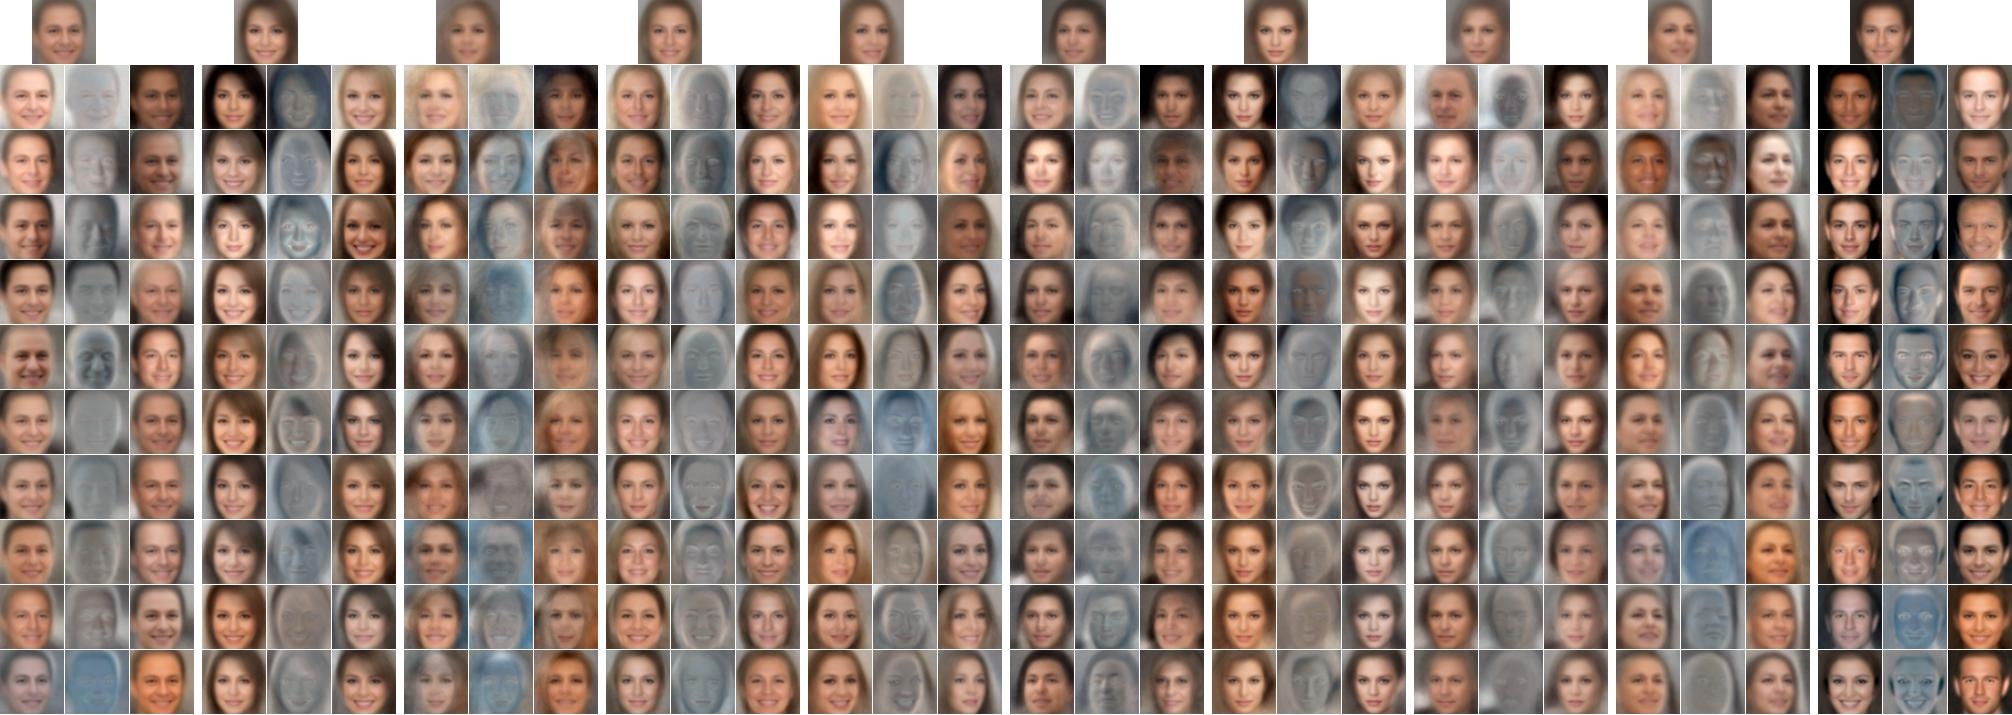

In [19]:
print("Visualizing the trained model...")
model_image = visualize_model(model, image_shape=image_shape, end_component=10)
fname = os.path.join(figures_dir, "model.jpg")
imwrite(fname, model_image)
display(Image(fname))

Generating random samples...


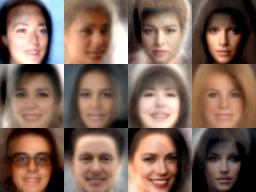

In [20]:
print("Generating random samples...")
rnd_samples, _ = model.sample(gird_size[0] * gird_size[1], with_noise=False)  # 100->n #gird_size[0]*gird_size[1]
mosaic = samples_to_mosaic_any_size(gird_size, samples=rnd_samples, image_shape=image_shape)
fname = os.path.join(figures_dir, "samples.jpg")
imwrite(fname, mosaic)
display(Image(fname))

### Showing outliers

In [21]:
gird_size = [int(x) for x in input("Enter gird size: ").split()]

Enter gird size: 1 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/156 [00:00<?, ?it/s]

Finding dataset outliers...


100%|██████████| 156/156 [00:30<00:00,  5.14it/s]


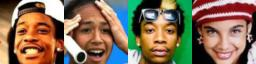

In [22]:
if find_outliers:
    print("Finding dataset outliers...")
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    all_ll = []
    for batch_x, _ in tqdm(loader):
        all_ll.append(model.log_prob(batch_x.to(device)))
    all_ll = torch.cat(all_ll, dim=0)
    ll_sorted = torch.argsort(all_ll).cpu().numpy()

    all_keys = [key for key in SequentialSampler(test_dataset)]
    outlier_samples, _ = zip(*[test_dataset[all_keys[ll_sorted[i]]] for i in range(gird_size[0] * gird_size[1])])
    mosaic = samples_to_mosaic_any_size(gird_size, torch.stack(outlier_samples), image_shape=image_shape)
    fname = os.path.join(figures_dir, "outliers.jpg")
    imwrite(fname, mosaic)
    display(Image(fname))

### Reconstructing original masked images 

In [23]:
mask_type = input("Enter the type of mask from following options: (a)centre (b)bottom (c)right (d)left (e)top: ")
gird_size = [int(x) for x in input("Enter gird size: ").split()]

Enter the type of mask from following options: (a)centre (b)bottom (c)right (d)left (e)top: centre
Enter gird size: 3 5


Reconstructing images from the trained model...


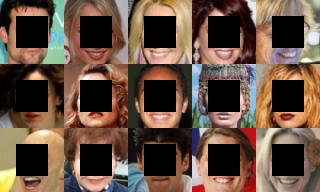

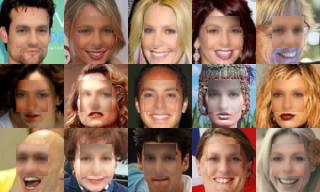

In [24]:
if reconstruction:
    print("Reconstructing images from the trained model...")
    n = gird_size[0] * gird_size[1]
    random_samples, _ = zip(
        *[test_dataset[k] for k in RandomSampler(test_dataset, replacement=True, num_samples=n)]
    )  # num_samples -> gird_size = [m1, m2]
    random_samples = torch.stack(random_samples)

    if inpainting:

        w = image_shape[0]
        mask = np.ones([3, w, w], dtype=np.float32)  # Hide part of each image

        if mask_type == "centre":
            mask[:, w // 4 : -w // 4, w // 4 : -w // 4] = 0  # Masking centre
        elif mask_type == "bottom":
            mask[:, w // 2 :, :] = 0  # Masking bottom half
        elif mask_type == "right":
            mask[:, :, w // 2 :] = 0  # Masking right half
        elif mask_type == "left":
            mask[:, :, : w // 2] = 0  # Masking left half
        else:
            mask[:, : w // 2, :] = 0  # Masking top half

        mask = torch.from_numpy(mask.flatten()).reshape([1, -1])
        random_samples *= mask
        used_features = torch.nonzero(mask.flatten()).flatten()
        reconstructed_samples = model.conditional_reconstruct(
            random_samples.to(device), observed_features=used_features
        ).cpu()
    else:
        reconstructed_samples = model.reconstruct(random_samples.to(device)).cpu()

    if inpainting:
        reconstructed_samples = random_samples * mask + reconstructed_samples * (1 - mask)

    mosaic_original = samples_to_mosaic_any_size(gird_size, random_samples, image_shape=image_shape)
    fname = os.path.join(figures_dir, "original_samples.jpg")
    imwrite(fname, mosaic_original)
    display(Image(fname))

    mosaic_recontructed = samples_to_mosaic_any_size(gird_size, reconstructed_samples, image_shape=image_shape)
    fname = os.path.join(figures_dir, "reconstructed_samples.jpg")
    imwrite(fname, mosaic_recontructed)
    display(Image(fname))